# Deep Learning ants & bees

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from sklearn.metrics import confusion_matrix

plt.ion #interactive mode

<function matplotlib.pyplot.ion()>

In [16]:
# load filenames for ants and bees images
ants_files = np.array(glob('data/train/ants/*') + glob('data/val/ants/*'))
bees_files = np.array(glob('data/train/bees/*') + glob('data/val/bees/*'))

# print number of images in each dataset
print('There are %d total ants images.' % len(ants_files))
print('There are %d total bees images.' % len(bees_files))

There are 194 total ants images.
There are 204 total bees images.


# Visualize a few Images

Let's visualize a few training images ants and bees

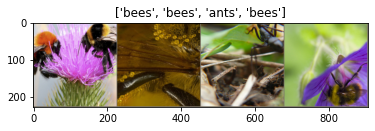

In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225 ])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

data_dir = "data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
               for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)# pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

1. general function to train a model
2. scheduling the learning rate
3. saving the best model

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('_' * 10)

        # Each epoch has a training and vailidation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode

            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the paramete gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss +=loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{}Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        
        
        # construct a figure that plots the loss over time
        #plt.plot(np.arange(0, epoch_loss.shape[0]), epoch_loss)
        #plt.title("Training Loss")
        #plt.xlabel("Epochs")
        #plt.ylabel("Loss")
        #plt.show()     
        
        return model

# Visualizing the model predictions

This is a generic function to display predictions for a few images

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.trainmode = was_training

# Fine tuning the convnet

Load a pretrained model and reset final fully connected layer

In [31]:
# If we change to False, the results of the predictions are bad.
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
__________
trainLoss:0.0023 Acc: 0.0164
trainLoss:0.0085 Acc: 0.0328
trainLoss:0.0101 Acc: 0.0492
trainLoss:0.0115 Acc: 0.0656
trainLoss:0.0123 Acc: 0.0820
trainLoss:0.0316 Acc: 0.0902
trainLoss:0.0410 Acc: 0.1025
trainLoss:0.0413 Acc: 0.1189
trainLoss:0.0685 Acc: 0.1230
trainLoss:0.0893 Acc: 0.1270
trainLoss:0.1025 Acc: 0.1352
trainLoss:0.1036 Acc: 0.1516
trainLoss:0.1096 Acc: 0.1639
trainLoss:0.1689 Acc: 0.1680
trainLoss:0.1846 Acc: 0.1762
trainLoss:0.1865 Acc: 0.1926
trainLoss:0.1877 Acc: 0.2090
trainLoss:0.1918 Acc: 0.2254
trainLoss:0.2022 Acc: 0.2377
trainLoss:0.2059 Acc: 0.2541
trainLoss:0.2073 Acc: 0.2705
trainLoss:0.2320 Acc: 0.2787
trainLoss:0.2533 Acc: 0.2869
trainLoss:0.2705 Acc: 0.2992
trainLoss:0.2723 Acc: 0.3156
trainLoss:0.3025 Acc: 0.3238
trainLoss:0.3076 Acc: 0.3361
trainLoss:0.3184 Acc: 0.3443
trainLoss:0.3301 Acc: 0.3525
trainLoss:0.3350 Acc: 0.3648
trainLoss:0.3501 Acc: 0.3770
trainLoss:0.3572 Acc: 0.3893
trainLoss:0.3952 Acc: 0.3975
trainLoss:0.3966 Acc:

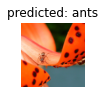

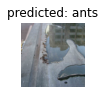

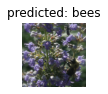

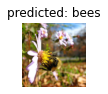

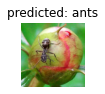

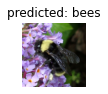

In [25]:
visualize_model(model_ft)

# Convnet as fixed feature extractor

1. freeze all the network except the final layer
2. need to set requires_grad == False to freeze the parameters

In [26]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
__________
trainLoss:0.0142 Acc: 0.0082
trainLoss:0.0231 Acc: 0.0205
trainLoss:0.0347 Acc: 0.0246
trainLoss:0.0484 Acc: 0.0246
trainLoss:0.0607 Acc: 0.0328
trainLoss:0.0709 Acc: 0.0451
trainLoss:0.0845 Acc: 0.0533
trainLoss:0.0985 Acc: 0.0615
trainLoss:0.1024 Acc: 0.0779
trainLoss:0.1169 Acc: 0.0861
trainLoss:0.1208 Acc: 0.1025
trainLoss:0.1419 Acc: 0.1066
trainLoss:0.1505 Acc: 0.1189
trainLoss:0.1577 Acc: 0.1352
trainLoss:0.1698 Acc: 0.1393
trainLoss:0.1848 Acc: 0.1434
trainLoss:0.1930 Acc: 0.1557
trainLoss:0.2057 Acc: 0.1639
trainLoss:0.2187 Acc: 0.1721
trainLoss:0.2290 Acc: 0.1803
trainLoss:0.2430 Acc: 0.1844
trainLoss:0.2499 Acc: 0.1967
trainLoss:0.2598 Acc: 0.2090
trainLoss:0.2685 Acc: 0.2213
trainLoss:0.2814 Acc: 0.2295
trainLoss:0.2933 Acc: 0.2418
trainLoss:0.3003 Acc: 0.2541
trainLoss:0.3189 Acc: 0.2623
trainLoss:0.3367 Acc: 0.2705
trainLoss:0.3444 Acc: 0.2869
trainLoss:0.3508 Acc: 0.2992
trainLoss:0.3593 Acc: 0.3115
trainLoss:0.3671 Acc: 0.3238
trainLoss:0.3849 Acc:

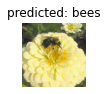

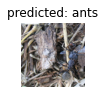

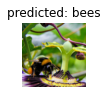

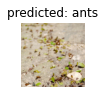

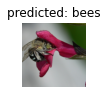

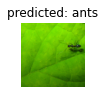

In [28]:
visualize_model(model_conv)

plt.ioff()
plt.show()